In [1]:
import os
import json
import pandas as pd
from datetime import datetime

DATA_DIR = 'data'

dynasty_rows = []
redraft_rows = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.json'):
        filepath = os.path.join(DATA_DIR, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            # Use 'lastUpdated' field for timestamp if available, else fallback to file mtime
            last_updated = data.get('lastUpdated')
            if last_updated:
                try:
                    # Remove 'Z' if present and parse as UTC
                    timestamp = datetime.fromisoformat(last_updated.replace('Z', '+00:00'))
                except Exception:
                    timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            else:
                timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            # Dynasty
            dynasty_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByDynasty') and 'teams' in data['rankedByDynasty']:
                for team in data['rankedByDynasty']['teams']:
                    team_name = team.get('owner', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        dynasty_row[f'dynasty_team_{team_name}'] = overall_value
            dynasty_rows.append(dynasty_row)
            # Redraft
            redraft_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByRedraft') and 'teams' in data['rankedByRedraft']:
                for team in data['rankedByRedraft']['teams']:
                    team_name = team.get('owner', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        redraft_row[f'redraft_team_{team_name}'] = overall_value
            redraft_rows.append(redraft_row)

# Create DataFrames
df_dynasty = pd.DataFrame(dynasty_rows).sort_values('timestamp').reset_index(drop=True)
df_redraft = pd.DataFrame(redraft_rows).sort_values('timestamp').reset_index(drop=True)

# Save to CSV (optional)
# df_dynasty.to_csv('dynasty_rankings_by_timestamp.csv', index=False)
# df_redraft.to_csv('redraft_rankings_by_timestamp.csv', index=False)

df_dynasty.tail()

,timestamp,filename,dynasty_team_dvdtequa,dynasty_team_mikulis,dynasty_team_dbrickashawc,dynasty_team_mmasison,dynasty_team_schlaich,dynasty_team_benslayer68,dynasty_team_dlaffs,dynasty_team_pjwelling,dynasty_team_hunterm19,dynasty_team_thinkfast86,dynasty_team_izzyfromdwntwn,dynasty_team_diddledum
95,2025-12-08 07:19:12.488000+00:00,fantasycalc_2025-12-08T07-19-12Z.json,83922,78344,78253,75310,73275,71246,69313,67620,68504,69096,65700,61014
96,2025-12-09 04:52:05.438641+00:00,fantasycalc_2025-12-09T07-17-25Z.json,83263,77104,78092,75792,73265,70961,69302,67957,67807,69096,65705,61619
97,2025-12-10 06:53:57.593399+00:00,fantasycalc_2025-12-10T07-17-55Z.json,82557,77261,77902,75837,73383,70331,68128,67517,67810,69046,65500,61761
98,2025-12-10 17:25:33.881616+00:00,fantasycalc_2025-12-11T07-19-44Z.json,82531,77518,77886,75865,74269,69946,68422,67356,67962,69152,65555,61651
99,2025-12-11 17:20:40.879665+00:00,fantasycalc_2025-12-12T07-18-40Z.json,82587,77568,78104,75848,74397,70249,68557,67339,68079,69375,65560,61608


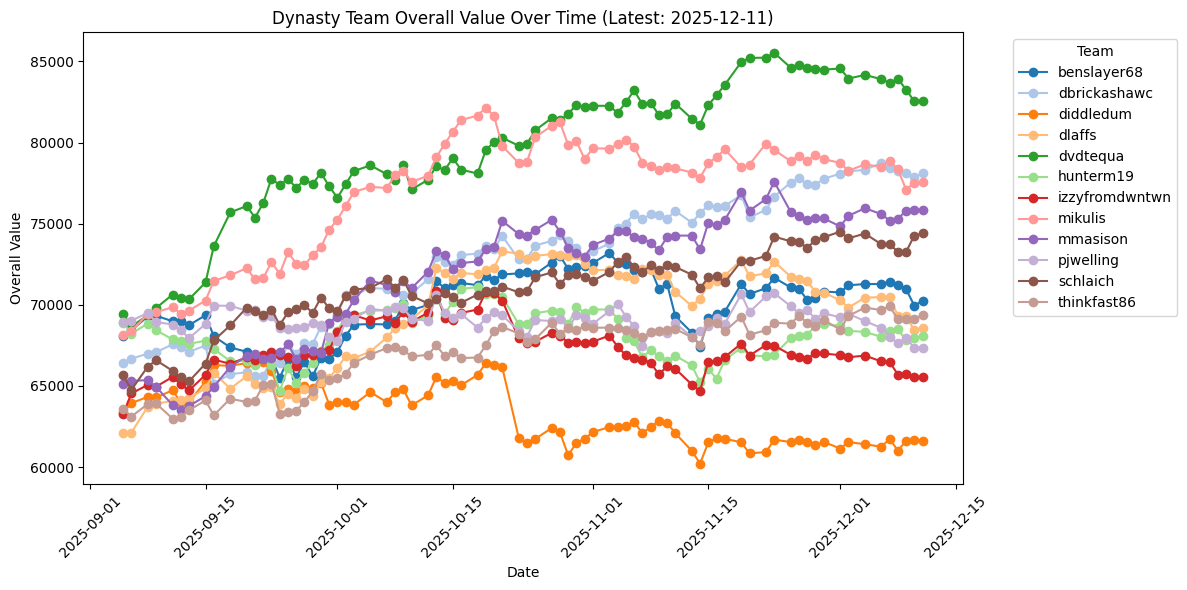

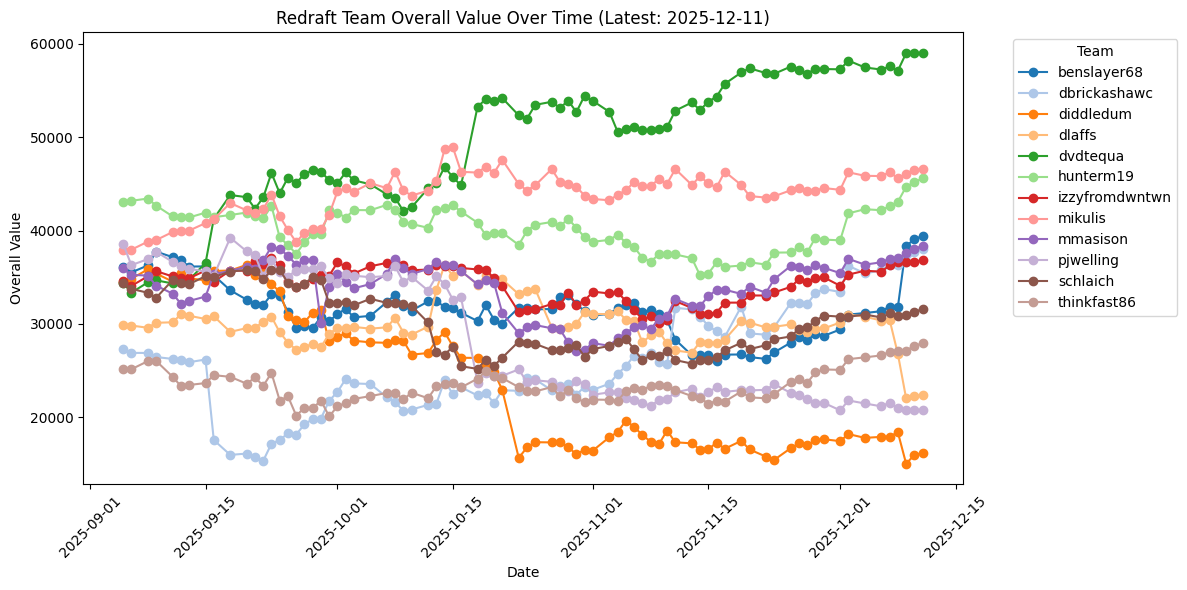

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use the union of all team columns for consistent color mapping
all_team_names = set(
    [col.replace('dynasty_team_', '') for col in df_dynasty.columns if col.startswith('dynasty_team_')] +
    [col.replace('redraft_team_', '') for col in df_redraft.columns if col.startswith('redraft_team_')]
    )
all_team_names = sorted(all_team_names)
color_map = {name: plt.get_cmap('tab20')(i % 20) for i, name in enumerate(all_team_names)}

# Dynasty plot with consistent colors and legend order
dynasty_team_cols = [f'dynasty_team_{name}' for name in all_team_names if f'dynasty_team_{name}' in df_dynasty.columns]
latest_dynasty_date = df_dynasty['timestamp'].max().date()

# Resample dynasty data to the latest value per 24-hour period
df_dynasty['date'] = df_dynasty['timestamp'].dt.floor('D')
df_dynasty_resampled = df_dynasty.sort_values('timestamp').groupby('date').last().reset_index()

# Dynasty plot
plt.figure(figsize=(12, 6))
for col, name in zip(dynasty_team_cols, all_team_names):
    if col in df_dynasty_resampled.columns:
        plt.plot(df_dynasty_resampled['date'], df_dynasty_resampled[col], marker='o', label=name, color=color_map[name])
plt.title(f'Dynasty Team Overall Value Over Time (Latest: {latest_dynasty_date})')
plt.xlabel('Date')
plt.ylabel('Overall Value')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', labels=all_team_names)
plt.tight_layout()
plt.show()

redraft_team_cols = [f'redraft_team_{name}' for name in all_team_names if f'redraft_team_{name}' in df_redraft.columns]
latest_redraft_date = df_redraft['timestamp'].max().date()

# Resample redraft data to the latest value per 24-hour period
df_redraft['date'] = df_redraft['timestamp'].dt.floor('D')
df_redraft_resampled = df_redraft.sort_values('timestamp').groupby('date').last().reset_index()

# Redraft plot
plt.figure(figsize=(12, 6))
for col, name in zip(redraft_team_cols, all_team_names):
    if col in df_redraft_resampled.columns:
        plt.plot(df_redraft_resampled['date'], df_redraft_resampled[col], marker='o', label=name, color=color_map[name])
plt.title(f'Redraft Team Overall Value Over Time (Latest: {latest_redraft_date})')
plt.xlabel('Date')
plt.ylabel('Overall Value')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', labels=all_team_names)
plt.tight_layout()
plt.show()

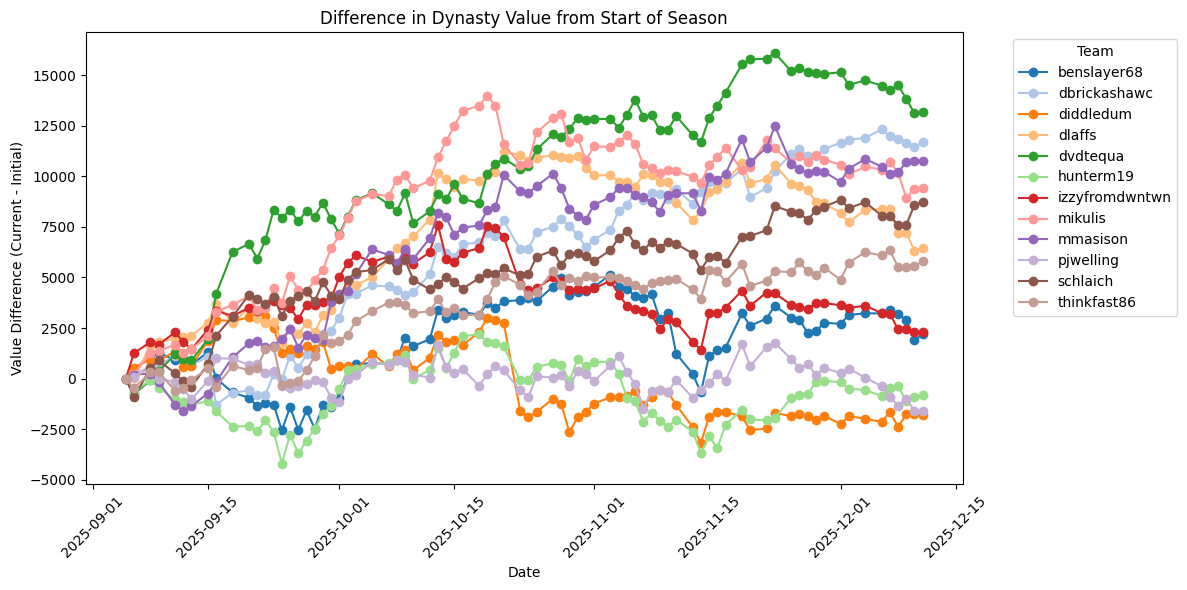

In [3]:
# Calculate the difference between the initial dynasty value at the start of the season and the current dynasty value
value_diff_cols = [name for name in all_team_names if f'dynasty_team_{name}' in df_dynasty.columns]
df_diff = pd.DataFrame({'timestamp': df_dynasty['timestamp']})
for name in value_diff_cols:
    dynasty_col = f'dynasty_team_{name}'
    initial_value = df_dynasty[dynasty_col].iloc[0]  # Assuming the first row is the start of the season
    df_diff[name] = df_dynasty[dynasty_col] - initial_value

# Resample data to the latest value per 24-hour period
df_diff['date'] = df_diff['timestamp'].dt.floor('D')
df_resampled = df_diff.sort_values('timestamp').groupby('date').last().reset_index()

# Plot the difference over time
plt.figure(figsize=(12, 6))
for name in value_diff_cols:
    if name in df_resampled.columns:
        plt.plot(df_resampled['date'], df_resampled[name], marker='o', label=name, color=color_map[name])
plt.title('Difference in Dynasty Value from Start of Season')
plt.xlabel('Date')
plt.ylabel('Value Difference (Current - Initial)')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', labels=value_diff_cols)
plt.tight_layout()
plt.show()